<a href="https://colab.research.google.com/github/alina-ohloblina/sales-analytics-portfolio/blob/main/Portfolio_project1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Single runnable cell: build dataset and print short description
from google.cloud import bigquery
import pandas as pd
import numpy as np

PROJECT_ID = "data-analytics-mate"
DATASET = "DA"
BQ = f"{PROJECT_ID}.{DATASET}"
client = bigquery.Client(project=PROJECT_ID)

sql = f"""
SELECT
  -- order date (use session.date as proxy)
  s.date AS order_date,
  -- session id
  s.ga_session_id AS session_id,
  -- geography / device / browser / language from session_params
  sp.continent AS continent,
  sp.country AS country,
  sp.device AS device,
  sp.browser AS browser,
  sp.mobile_model_name AS device_model_name,
  sp.operating_system AS operating_system,
  sp.language AS browser_language,
  -- traffic fields from session_params
  sp.medium AS traffic_source_info,
  sp.channel AS traffic_channel,
  -- registered user id and account flags (LEFT JOINs keep all orders/sessions)
  acs.account_id AS registered_user_id,
  a.is_verified AS email_confirmed,
  a.is_unsubscribed AS is_unsubscribed,
  -- product fields
  p.category AS product_category,
  p.name AS product_name,
  CAST(p.price AS FLOAT64) AS price,
  p.short_description AS short_product_description
FROM `{BQ}.order` o
LEFT JOIN `{BQ}.session` s
  ON o.ga_session_id = s.ga_session_id
LEFT JOIN `{BQ}.session_params` sp
  ON s.ga_session_id = sp.ga_session_id
LEFT JOIN `{BQ}.account_session` acs
  ON s.ga_session_id = acs.ga_session_id
LEFT JOIN `{BQ}.account` a
  ON acs.account_id = a.id
LEFT JOIN `{BQ}.product` p
  ON o.item_id = p.item_id
"""

print("Running BigQuery export (may take some time depending on data size)...")
df = client.query(sql).to_dataframe()
print("Query finished — rows:", len(df))

# --------------------
# Post-processing
# --------------------
# order_date -> datetime
df['order_date'] = pd.to_datetime(df['order_date'], errors='coerce')

# price numeric
if 'price' in df.columns:
    df['price'] = pd.to_numeric(df['price'], errors='coerce')

# Normalize boolean flags using nullable Int64
# account.is_verified -> email_confirmed (1/0/NA)
if 'email_confirmed' in df.columns:
    df['email_confirmed'] = df['email_confirmed'].replace({True:1, False:0, 'true':1, 'false':0, '1':1, '0':0})
    df['email_confirmed'] = pd.to_numeric(df['email_confirmed'], errors='coerce').astype('Int64')

# account.is_unsubscribed -> subscribed_to_newsletter (invert; preserve NA)
if 'is_unsubscribed' in df.columns:
    # convert to numeric nullable then invert
    df['is_unsubscribed'] = pd.to_numeric(df['is_unsubscribed'], errors='coerce').astype('Int64')
    df['subscribed_to_newsletter'] = df['is_unsubscribed'].map(
        lambda x: pd.NA if pd.isna(x) else (0 if int(x)==1 else 1)
    ).astype('Int64')
    # drop intermediate column if you prefer
    df = df.drop(columns=['is_unsubscribed'])

# Ensure registered_user_id numeric where possible
if 'registered_user_id' in df.columns:
    df['registered_user_id'] = pd.to_numeric(df['registered_user_id'], errors='coerce').astype('Int64')

# Reorder columns to match requested list
desired_cols = [
    'order_date','session_id','continent','country','device','browser','device_model_name',
    'operating_system','browser_language','traffic_source_info','traffic_channel',
    'registered_user_id','email_confirmed','subscribed_to_newsletter',
    'product_category','product_name','price','short_product_description'
]
cols_present = [c for c in desired_cols if c in df.columns]
df = df[cols_present]

# Save CSV for analysis / Tableau
out_csv = "final_analytical_dataset.csv"
df.to_csv(out_csv, index=False)
print("Saved CSV:", out_csv)

# --------------------
# Short description (printed)
# --------------------
total_columns = df.shape[1]
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
# include nullable Int64 as numeric via pandas' convert
nullable_ints = [c for c in df.columns if str(df[c].dtype).startswith('Int')]
# consider price as numeric explicitly
if 'price' in df.columns and 'price' not in numeric_cols:
    numeric_cols.append('price')
# merge with nullable ints
numeric_cols = sorted(list(set(numeric_cols + nullable_ints)))

datetime_cols = df.select_dtypes(include=['datetime64[ns]']).columns.tolist()
categorical_cols = [c for c in df.columns if c not in numeric_cols + datetime_cols]

unique_sessions = int(df['session_id'].nunique()) if 'session_id' in df.columns else 'N/A'
time_min = df['order_date'].min() if 'order_date' in df.columns else pd.NaT
time_max = df['order_date'].max() if 'order_date' in df.columns else pd.NaT

missing_counts = df.isnull().sum().sort_values(ascending=False)

print("\n--- Short dataset description ---")
print("Total number of columns:", total_columns)
print("Numeric columns (count):", len(numeric_cols), numeric_cols)
print("Categorical columns (count):", len(categorical_cols), categorical_cols)
print("Datetime columns (count):", len(datetime_cols), datetime_cols)
print("Number of unique sessions:", unique_sessions)
print("Time period covered:", time_min, "to", time_max)
print("\nMissing values by column (top 12):")
print(missing_counts.head(12))

# Brief explanation about missingness
print("\nNotes on missing values:")
print("- registered_user_id, email_confirmed, subscribed_to_newsletter are expected to have many missing values because many sessions/orders are from unregistered users.")
print("- session_params-derived fields (continent, country, device, browser_language, traffic fields) may be missing for some sessions if parameters were not recorded.")
print("- product fields (product_category, product_name, price, short_product_description) will be missing if an order row had item_id not matching product table or if product metadata missing.")


Running BigQuery export (may take some time depending on data size)...
Query finished — rows: 33538
Saved CSV: final_analytical_dataset.csv

--- Short dataset description ---
Total number of columns: 18
Numeric columns (count): 5 ['email_confirmed', 'price', 'registered_user_id', 'session_id', 'subscribed_to_newsletter']
Categorical columns (count): 12 ['continent', 'country', 'device', 'browser', 'device_model_name', 'operating_system', 'browser_language', 'traffic_source_info', 'traffic_channel', 'product_category', 'product_name', 'short_product_description']
Datetime columns (count): 1 ['order_date']
Number of unique sessions: 33538
Time period covered: 2020-11-01 00:00:00 to 2021-01-27 00:00:00

Missing values by column (top 12):
subscribed_to_newsletter    30757
email_confirmed             30757
registered_user_id          30757
browser_language            11007
session_id                      0
order_date                      0
browser                         0
continent        

In [ ]:
# Single cell: full answers + visualizations for the requested questions
import pandas as pd, numpy as np
import matplotlib.pyplot as plt, seaborn as sns
import os

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10,6)

# Load dataset
fn = "final_analytical_dataset.csv"
df = pd.read_csv(fn, parse_dates=['order_date'], low_memory=False)

# Ensure price numeric and drop negative/NaN prices for sales sums
df['price'] = pd.to_numeric(df['price'], errors='coerce')
sales_df = df.dropna(subset=['price']).copy()
sales_df = sales_df[sales_df['price'] >= 0]

os.makedirs("analysis_outputs", exist_ok=True)

# Helper: safe groupby-sum
def sum_by(field):
    return sales_df.groupby(field)['price'].sum().sort_values(ascending=False)

def count_orders_by(field):
    return df.groupby(field)['session_id'].count().sort_values(ascending=False)

# 1) Top-3 continents by total sales and top-3 by number of orders
cont_sales = sum_by('continent').dropna()
cont_orders = count_orders_by('continent').dropna()
cont_sales.head(10).to_csv("analysis_outputs/continent_sales.csv")
cont_orders.head(10).to_csv("analysis_outputs/continent_orders.csv")

print("\nTop-3 continents by total sales:")
print(cont_sales.head(3))
print("\nTop-3 continents by number of orders (sessions):")
print(cont_orders.head(3))

plt.figure()
cont_sales.plot(kind='bar', color='C0')
plt.title("Total sales by continent")
plt.ylabel("Total sales")
plt.tight_layout()
plt.savefig("analysis_outputs/sales_by_continent.png")
plt.close()

plt.figure()
cont_orders.plot(kind='bar', color='C1')
plt.title("Number of orders (sessions) by continent")
plt.ylabel("Order count (sessions)")
plt.tight_layout()
plt.savefig("analysis_outputs/orders_by_continent.png")
plt.close()

# 1b) Top-5 countries by sales and by number of orders
country_sales = sum_by('country').dropna()
country_orders = count_orders_by('country').dropna()
country_sales.head(20).to_csv("analysis_outputs/country_sales.csv")
country_orders.head(20).to_csv("analysis_outputs/country_orders.csv")

print("\nTop-5 countries by sales:")
print(country_sales.head(5))
print("\nTop-5 countries by number of orders (sessions):")
print(country_orders.head(5))

plt.figure()
country_sales.head(10).plot(kind='bar', color='C2')
plt.title("Top 10 countries by sales")
plt.ylabel("Total sales")
plt.tight_layout()
plt.savefig("analysis_outputs/top10_countries_sales.png")
plt.close()

# 2) Top-10 product categories by total sales
cat_sales = sum_by('product_category').dropna()
top10_cats = cat_sales.head(10)
top10_cats.to_csv("analysis_outputs/top10_categories.csv")
print("\nTop-10 product categories by total sales:")
print(top10_cats)

plt.figure()
top10_cats.plot(kind='bar', color='C3')
plt.title("Top-10 product categories by sales")
plt.ylabel("Total sales")
plt.tight_layout()
plt.savefig("analysis_outputs/top10_categories.png")
plt.close()

# 3) Top-10 categories in the country with highest sales
top_country = country_sales.index[0] if not country_sales.empty else None
if top_country:
    cat_sales_top_country = sales_df[sales_df['country']==top_country].groupby('product_category')['price'].sum().sort_values(ascending=False).head(10)
    cat_sales_top_country.to_csv("analysis_outputs/top10_categories_top_country.csv")
    print(f"\nTop-10 product categories in top country ({top_country}):")
    print(cat_sales_top_country)
    plt.figure()
    cat_sales_top_country.plot(kind='bar', color='C4')
    plt.title(f"Top-10 categories in {top_country}")
    plt.ylabel("Total sales")
    plt.tight_layout()
    plt.savefig("analysis_outputs/top10_categories_in_topcountry.png")
    plt.close()
    # Compare overall vs top country overlap/ differences
    overlap = set(top10_cats.index).intersection(set(cat_sales_top_country.index))
    print(f"\nOverlap between overall top-10 and {top_country} top-10: {len(overlap)}/10. Examples of differences: categories in top country but not overall top-10:")
    print([c for c in cat_sales_top_country.index if c not in top10_cats.index][:10])
else:
    print("\nNo country sales data available to compute top country breakdown.")

# 4) Sales by device types and device models (as % of total sales)
device_sales = sum_by('device').dropna()
device_pct = device_sales / device_sales.sum() * 100
device_pct.to_csv("analysis_outputs/device_sales_pct.csv")
print("\nSales by device type (% of total sales):")
print(device_pct.round(2))

plt.figure()
device_pct.plot(kind='pie', autopct='%1.1f%%', ylabel='')
plt.title("Sales share by device type (%)")
plt.tight_layout()
plt.savefig("analysis_outputs/device_share_pie.png")
plt.close()

# device models top-10
model_field = 'device_model_name'
if model_field in sales_df.columns:
    model_sales = sales_df.groupby(model_field)['price'].sum().sort_values(ascending=False).head(10)
    model_sales.to_csv("analysis_outputs/top10_device_models.csv")
    print("\nTop-10 device models by sales:")
    print(model_sales)
    plt.figure()
    model_sales.plot(kind='barh', color='C5')
    plt.title("Top-10 device models by sales")
    plt.xlabel("Total sales")
    plt.tight_layout()
    plt.savefig("analysis_outputs/top10_device_models.png")
    plt.close()
else:
    print("\nNo device model field found.")

# 5) Sales by traffic sources (as % of total sales)
traffic_field = 'traffic_source_info' if 'traffic_source_info' in sales_df.columns else 'traffic_channel' if 'traffic_channel' in sales_df.columns else None
if traffic_field:
    traffic_sales = sum_by(traffic_field).dropna()
    traffic_pct = traffic_sales / traffic_sales.sum() * 100
    traffic_pct.head(20).to_csv("analysis_outputs/traffic_sales_pct.csv")
    print("\nTop traffic sources by % of sales (top 10):")
    print(traffic_pct.head(10).round(2))
    plt.figure()
    traffic_pct.head(10).plot(kind='bar', color='C6')
    plt.title("Top traffic sources by % of sales")
    plt.ylabel("% of sales")
    plt.tight_layout()
    plt.savefig("analysis_outputs/top_traffic_sources.png")
    plt.close()
else:
    print("\nNo traffic fields found to analyze.")

# 6) Percentage of registered users who confirmed email
if 'registered_user_id' in df.columns and df['registered_user_id'].notnull().any():
    regs = df[df['registered_user_id'].notnull()].copy()
    # drop duplicates by user to compute % of users confirmed
    user_flags = regs.groupby('registered_user_id').agg(
        email_confirmed_any = ('email_confirmed','max'),
        subscribed_any = ('subscribed_to_newsletter','max')
    )
    # email_confirmed_any may be NA for some users;
    total_regs = len(user_flags)
    confirmed_count = int(user_flags['email_confirmed_any'].fillna(0).astype(int).sum())
    pct_confirmed = confirmed_count / total_regs * 100 if total_regs>0 else np.nan
    print(f"\nRegistered users total: {total_regs}")
    print(f"Users who confirmed email (count): {confirmed_count}, percent: {pct_confirmed:.2f}%")
    # 7) Percentage of registered users unsubscribed from newsletter
    unsub_count = int(user_flags['subscribed_any'].isna().sum())  # placeholder; compute correctly below
    # subscribed_any: 1=subscribed, 0=not subscribed.
    subs_info = user_flags['subscribed_any'].dropna()
    # Count unsubscribed = users with subscribed_any==0
    unsubscribed_users = int((user_flags['subscribed_any']==0).sum())
    pct_unsubscribed = unsubscribed_users / total_regs * 100 if total_regs>0 else np.nan
    print(f"Registered users unsubscribed (count): {unsubscribed_users}, percent: {pct_unsubscribed:.2f}%")
else:
    print("\nNo registered_user_id data found to compute registered-user percentages.")

# 8) Does sales behavior differ between unsubscribed vs subscribed?
if 'subscribed_to_newsletter' in df.columns:
    # consider orders with known subscription status
    subs_orders = sales_df[sales_df['subscribed_to_newsletter']==1]
    unsubs_orders = sales_df[sales_df['subscribed_to_newsletter']==0]
    mean_sub = subs_orders['price'].mean() if len(subs_orders)>0 else np.nan
    mean_unsub = unsubs_orders['price'].mean() if len(unsubs_orders)>0 else np.nan
    count_sub = subs_orders.shape[0]
    count_unsub = unsubs_orders.shape[0]
    print(f"\nSales behavior by subscription (orders with known status):")
    print(f"Subscribed orders: {count_sub}, mean order value: {mean_sub:.2f}")
    print(f"Unsubscribed orders: {count_unsub}, mean order value: {mean_unsub:.2f}")
    # Save distributions summary
    pd.Series({'mean_subscribed': mean_sub, 'count_subscribed':count_sub, 'mean_unsubscribed':mean_unsub, 'count_unsubscribed':count_unsub}).to_csv("analysis_outputs/subscription_sales_summary.csv")
    # Boxplot
    plt.figure()
    sns.boxplot(x='subscribed_to_newsletter', y='price', data=sales_df[sales_df['subscribed_to_newsletter'].isin([0,1])])
    plt.title("Order price distribution by subscription status (0=unsubscribed,1=subscribed)")
    plt.tight_layout()
    plt.savefig("analysis_outputs/price_by_subscription_boxplot.png")
    plt.close()
else:
    print("\nSubscribed flag not available to compare behaviors.")

# 9) Countries with most registered users
if 'registered_user_id' in df.columns:
    regs_by_country = df[df['registered_user_id'].notnull()].groupby('country')['registered_user_id'].nunique().sort_values(ascending=False)
    regs_by_country.head(10).to_csv("analysis_outputs/registered_users_by_country.csv")
    print("\nTop countries by number of registered users:")
    print(regs_by_country.head(10))
    plt.figure()
    regs_by_country.head(10).plot(kind='bar', color='C7')
    plt.title("Top countries by registered users")
    plt.ylabel("Unique registered users")
    plt.tight_layout()
    plt.savefig("analysis_outputs/registered_users_by_country.png")
    plt.close()
else:
    print("\nNo registered_user_id column to compute registered users by country.")

# Extra insights  AOV by continent, conversion proxy
# Average order value (AOV) by continent
aov_cont = sales_df.groupby('continent')['price'].mean().sort_values(ascending=False)
aov_cont.to_csv("analysis_outputs/aov_by_continent.csv")
print("\nAverage order value (AOV) by continent:")
print(aov_cont)

# Conversion proxy: sessions with price>0 divided by total sessions by traffic channel
if 'traffic_channel' in df.columns and 'session_id' in df.columns:
    sess = df[['session_id','traffic_channel']].drop_duplicates()
    sess_sales = sales_df[['session_id']].drop_duplicates()
    sess = sess.merge(sess_sales.assign(bought=1), on='session_id', how='left').fillna(0)
    conv_by_channel = sess.groupby('traffic_channel')['bought'].mean().dropna().sort_values(ascending=False)
    conv_by_channel.to_csv("analysis_outputs/conversion_by_channel.csv")
    print("\nConversion proxy (fraction of sessions with orders) by traffic channel (top 10):")
    print(conv_by_channel.head(10))
    plt.figure()
    conv_by_channel.head(10).plot(kind='bar', color='C8')
    plt.title("Conversion proxy by traffic channel")
    plt.ylabel("Fraction of sessions with orders")
    plt.tight_layout()
    plt.savefig("analysis_outputs/conversion_by_channel.png")
    plt.close()
else:
    print("\nInsufficient data for conversion proxy by traffic channel.")

print("\n\n--- Files saved in analysis_outputs/ ---")
print("Charts: sales_by_continent.png, orders_by_continent.png, top10_countries_sales.png, top10_categories.png, top10_categories_in_topcountry.png, device_share_pie.png, top10_device_models.png, top_traffic_sources.png, price_by_subscription_boxplot.png, registered_users_by_country.png, conversion_by_channel.png (when available)")
print("CSVs: continent_sales.csv, continent_orders.csv, country_sales.csv, country_orders.csv, top10_categories.csv, top10_categories_top_country.csv, top10_device_models.csv, traffic_sales_pct.csv, top_traffic_sources.csv, registered_users_by_country.csv, aov_by_continent.csv, conversion_by_channel.csv (when available)")

print("\n\nSummary conclusions (automatic brief):")

print("- The top-3 continents by sales are:", ', '.join(cont_sales.head(3).index.astype(str).tolist()) if not cont_sales.empty else "N/A")
print("- The top-5 countries by sales are:", ', '.join(country_sales.head(5).index.astype(str).tolist()) if not country_sales.empty else "N/A")
print("- Top product categories overall listed in analysis_outputs/top10_categories.csv")
if top_country:
    print(f"- Category mix in {top_country} saved; compare top10 lists to see differences.")
print("- Device and traffic breakdowns saved; check device_share_pie.png and top_traffic_sources.png for distributions.")
print("- Registered-user confirmation and newsletter unsubscribe rates printed above; check analysis_outputs for exact numbers and CSVs.")



Top-3 continents by total sales:
continent
Americas    17665280.0
Asia         7601298.3
Europe       5934624.2
Name: price, dtype: float64

Top-3 continents by number of orders (sessions):
continent
Americas    18553
Asia         7950
Europe       6261
Name: session_id, dtype: int64

Top-5 countries by sales:
country
United States     13943553.9
India              2809762.0
Canada             2437921.0
United Kingdom      938317.9
France              710692.8
Name: price, dtype: float64

Top-5 countries by number of orders (sessions):
country
United States     14673
India              3029
Canada             2560
United Kingdom     1029
France              678
Name: session_id, dtype: int64

Top-10 product categories by total sales:
product_category
Sofas & armchairs                   8388254.5
Chairs                              6147748.8
Beds                                4919725.0
Bookcases & shelving units          3640818.1
Cabinets & cupboards                2336499.5
Outdoor 

Insight analysis

### Top continents and countries by sales and orders

- Top-3 continents by total sales: Americas (€17,665,280), Asia (€7,601,298.30), Europe (€5,934,624.20).  
- Top-3 continents by order count: Americas (18,553 sessions), Asia (7,950), Europe (6,261).  
- Top-5 countries by total sales: United States (€13,943,553.90), India (€2,809,762.00), Canada (€2,437,921.00), United Kingdom (€938,317.90), France (€710,692.80).  
- Top-5 countries by order count: United States (14,673), India (3,029), Canada (2,560), United Kingdom (1,029), France (678).  

Interpretation and recommendation  
- Americas (driven mostly by the United States) dominates both revenue and volume. Prioritize marketing and inventory efforts in the US and Canada.  
- Asia is the second highest revenue region but shows a higher relative gap between revenue and orders than Americas, indicating higher-value segments or uneven product mix; investigate pricing and category mix by country in Asia.  
- Europe lags both in revenue and orders; consider targeted growth campaigns in high-potential European countries.

---

### Top product categories overall and in the top country

- Top-10 product categories by total sales:
  1. Sofas & armchairs €8,388,254.5  
  2. Chairs €6,147,748.8  
  3. Beds €4,919,725.0  
  4. Bookcases & shelving units €3,640,818.1  
  5. Cabinets & cupboards €2,336,499.5  
  6. Outdoor furniture €2,142,222.2  
  7. Tables & desks €1,790,307.5  
  8. Chests of drawers & drawer units €906,562.5  
  9. Bar furniture €735,503.0  
  10. Children's furniture €467,697.0  

- Top-10 categories in the United States mirror the global top-10 in the same order and amounts for the US market. Overlap between global top-10 and US top-10 is 10 out of 10.

Interpretation and recommendation  
- Sofas & armchairs and Chairs are the clear revenue leaders; merchandising, cross-sell bundles, and ad spend should focus on these categories.  
- The US category mix mirrors the global mix, so global product strategies are likely to scale in the US; local promotions can be category-focused rather than category-shifted.

---

### Sales by device types and models

- Sales share by device type: desktop 59.00%, mobile 38.73%, tablet 2.26%.  
- Top device models by sales include Chrome (€8,899,523.9), <Other> (€6,535,330.8), Safari (€6,491,062.1), iPhone (€6,420,776.3), ChromeBook (€1,830,458.7) and others.

Interpretation and recommendation  
- Desktop remains the primary revenue channel and should receive high priority for full-featured checkout and upsell placement.  
- Mobile accounts for nearly 39% of sales; optimize mobile UX and speed and prioritize mobile payment options.  
- Device-model breakdown shows a mix of browsers and devices; ensure cross-browser testing and targeted creative sizes for iPhone and Safari users.

---

### Sales by traffic sources

- Traffic source share of sales (top entries): organic 34.20%, (none) 23.44%, referral 17.65%, <Other> 14.05%, (data deleted) 6.39%, cpc 4.27%.

Interpretation and recommendation  
- Organic search is the largest single source of revenue and should be prioritized for SEO investment.  
- A large (none) and <Other> share suggest gaps in tracking or ambiguous source tagging; improve UTM and tracking hygiene.  
- Paid channels (cpc) contribute a smaller share but can drive spikes; use paid strategically for acquisition and promotions.

---

### Registered-user metrics

- Registered users total: 2,781.  
- Registered users confirmed email: 1,989 users, 71.52% confirmed.  
- Registered users unsubscribed from newsletter: 447 users, 16.07% unsubscribed.

Interpretation and recommendation  
- Email confirmation rate of ~71.5% is solid but has room to improve; implement frictionless verification flows and email reminders to raise confirmed rates.  
- Newsletter unsubscribe rate of ~16% is moderate; analyze email content and cadence to reduce churn while preserving engagement.

---

### Sales behavior by newsletter subscription

- Orders with known subscription status: subscribed orders 2,334, mean order value €921.51; unsubscribed orders 447, mean order value €965.82.  
- The unsubscribed group shows a slightly higher mean order value than subscribed users.

Interpretation and recommendation  
- Mean AOV is not substantially different between subscribed and unsubscribed users. Differences should be tested for statistical significance before changing strategy.  
- Consider segment-level offers: exclude unsubscribed users from email campaigns but consider targeted onsite or paid-channel promos if their AOV is higher.

---

### Countries with the most registered users

- Top countries by number of registered users: United States 1,207, India 246, Canada 207, United Kingdom 88, France 56, Germany 56, Taiwan 51, Spain 48, China 48, Singapore 44.

Interpretation and recommendation  
- The registered user base is concentrated in the US; invest in retention and personalized experiences for US users.  
- Growth opportunities exist in India and Canada where registration counts are substantial; run localized acquisition and onboarding experiments.

---

### Additional insights

- Average order value by continent shows small differences: (not set) €1,043.20, Oceania €1,003.38, Africa €977.08, Asia €956.14, Americas €952.15, Europe €947.87. AOV is broadly similar across regions with mild variation.  
- Conversion proxy by traffic channel reports 1.0 for listed channels, indicating the current proxy method marks sessions with orders only; refine conversion metric by counting sessions with and without orders to get realistic conversion rates.  
- Category concentration is pronounced with sofas, chairs, and beds driving the majority of revenue; a Pareto analysis would likely show a strong top-category concentration.

Actionable next steps you can take immediately  
- Fix tracking gaps for the large (none) traffic source and <Other> categories.  
- Prioritize UX and performance improvements on desktop and mobile checkout flows.  
- Focus inventory, promotions, and paid campaigns on top categories and top-country markets, especially the United States.  
- Improve email verification flow to raise confirmed rates and segment email campaigns to reduce unsubscribes.



In [ ]:
# Pivot tables
import pandas as pd
from IPython.display import display

# Load dataset
df = pd.read_csv("final_analytical_dataset.csv", parse_dates=['order_date'], low_memory=False)
df['price'] = pd.to_numeric(df['price'], errors='coerce')

# Helper to safely display a pivot
def safe_display(df_pivot, name):
    if df_pivot is None or df_pivot.empty:
        print(f"\n{name}: pivot is empty or no data available.")
    else:
        print(f"\n{name}:")
        display(df_pivot)

# Determine columns
tc_col = 'traffic_channel' if 'traffic_channel' in df.columns else ('traffic_source_info' if 'traffic_source_info' in df.columns else None)
device_col = 'device' if 'device' in df.columns else None

# --- Pivot 1: Number of sessions by traffic channel x device (ignore missing)
if tc_col and device_col:
    p1_df = df[['session_id', tc_col, device_col]].dropna(subset=[tc_col, device_col]).drop_duplicates()
    if p1_df.empty:
        pivot_sessions = pd.DataFrame()
    else:
        pivot_sessions = pd.pivot_table(
            p1_df,
            index=tc_col,
            columns=device_col,
            values='session_id',
            aggfunc=pd.Series.nunique,
            fill_value=0
        )
    safe_display(pivot_sessions, "Pivot 1 — sessions by traffic channel x device (rows=traffic channel, cols=device)")
else:
    print("\nPivot 1 skipped: traffic channel or device column not found in dataset.")

# --- Pivot 2: Total sales by product category (top-10) across top-5 countries
sales_df = df.dropna(subset=['price']).copy()
if not sales_df.empty and 'product_category' in sales_df.columns and 'country' in sales_df.columns:
    cat_sales = sales_df.groupby('product_category')['price'].sum().sort_values(ascending=False)
    top10_cats = cat_sales.head(10).index.tolist()
    country_sales = sales_df.groupby('country')['price'].sum().sort_values(ascending=False)
    top5_countries = country_sales.head(5).index.tolist()
    p2_df = sales_df[sales_df['product_category'].isin(top10_cats) & sales_df['country'].isin(top5_countries)]
    if p2_df.empty:
        pivot_cat_country = pd.DataFrame()
    else:
        pivot_cat_country = pd.pivot_table(
            p2_df,
            index='product_category',
            columns='country',
            values='price',
            aggfunc='sum',
            fill_value=0
        ).reindex(top10_cats)  # ensure top-10 order
    safe_display(pivot_cat_country, "Pivot 2 — sales by top-10 categories x top-5 countries")
else:
    print("\nPivot 2 skipped: insufficient sales/category/country data.")

# --- Custom Pivot A: AOV by continent x device (display only)
if 'continent' in df.columns and device_col:
    session_sales = sales_df.groupby(['session_id','continent', device_col])['price'].sum().reset_index()
    if session_sales.empty:
        aov_pivot = pd.DataFrame()
    else:
        aov_pivot = pd.pivot_table(
            session_sales,
            index='continent',
            columns=device_col,
            values='price',
            aggfunc='mean',
            fill_value=0
        ).round(2)
    safe_display(aov_pivot, "Custom Pivot A — AOV by continent x device")
else:
    print("\nCustom Pivot A skipped: continent or device column missing.")

# --- Custom Pivot B: Orders and total sales by traffic channel x country (display only)
if tc_col and 'country' in df.columns:
    tc_sales = sales_df.groupby(tc_col)['price'].sum().sort_values(ascending=False)
    top_tc = tc_sales.head(8).index.tolist() if not tc_sales.empty else []
    top_countries = top5_countries if 'top5_countries' in locals() and top5_countries else (sales_df.groupby('country')['price'].sum().sort_values(ascending=False).head(5).index.tolist() if not sales_df.empty else [])
    pB_df = sales_df[sales_df[tc_col].isin(top_tc) & sales_df['country'].isin(top_countries)]
    if pB_df.empty:
        pivot_orders = pd.DataFrame()
        pivot_sales = pd.DataFrame()
    else:
        pivot_orders = pd.pivot_table(
            pB_df,
            index=tc_col,
            columns='country',
            values='session_id',
            aggfunc=pd.Series.nunique,
            fill_value=0
        )
        pivot_sales = pd.pivot_table(
            pB_df,
            index=tc_col,
            columns='country',
            values='price',
            aggfunc='sum',
            fill_value=0
        ).round(2)
    safe_display(pivot_orders, "Custom Pivot B — unique sessions by traffic channel x country")
    safe_display(pivot_sales, "Custom Pivot B — total sales by traffic channel x country")



Pivot 1 — sessions by traffic channel x device (rows=traffic channel, cols=device):


device,desktop,mobile,tablet
traffic_channel,,,
Direct,4655,2985,160
Organic Search,7011,4655,255
Paid Search,5261,3574,207
Social Search,1594,1065,57
Undefined,1181,834,44



Pivot 2 — sales by top-10 categories x top-5 countries:


country,Canada,France,India,United Kingdom,United States
product_category,,,,,
Sofas & armchairs,692427.5,187735.0,788430.0,234812.0,3707144.5
Chairs,417740.8,134029.4,544309.2,188519.4,2619773.8
Beds,354772.0,116414.0,358319.5,133816.0,2213058.0
Bookcases & shelving units,278981.9,73830.0,364507.4,113987.6,1567606.9
Cabinets & cupboards,181802.0,59101.5,191888.0,71684.5,994545.5
Outdoor furniture,185322.8,40486.4,162289.4,57002.4,929245.2
Tables & desks,132678.0,42299.0,186157.5,49374.0,777865.0
Chests of drawers & drawer units,71952.0,21544.5,73111.0,36784.0,382388.0
Bar furniture,51724.0,11199.0,57657.0,22103.0,330805.0



Custom Pivot A — AOV by continent x device:


device,desktop,mobile,tablet
continent,,,
(not set),1032.87,1117.70,70.00
Africa,1030.02,907.48,987.14
Americas,962.17,936.26,966.60
Asia,940.15,971.46,1110.69
Europe,955.43,935.09,978.02
Oceania,1039.48,942.73,847.78



Custom Pivot B — unique sessions by traffic channel x country:


country,Canada,France,India,United Kingdom,United States
traffic_channel,,,,,
Direct,614,156,744,236,3411
Organic Search,883,247,1086,379,5182
Paid Search,723,191,789,289,3947
Social Search,196,45,230,73,1211
Undefined,144,39,180,52,922



Custom Pivot B — total sales by traffic channel x country:


country,Canada,France,India,United Kingdom,United States
traffic_channel,,,,,
Direct,609806.3,169299.5,700256.0,203728.9,3346860.3
Organic Search,873719.7,261008.6,972575.7,356438.9,4958993.0
Paid Search,674902.0,192421.3,729970.0,278652.6,3589463.4
Social Search,151244.2,46713.4,215703.8,51836.0,1132651.1
Undefined,128248.8,41250.0,191256.5,47661.5,915586.1


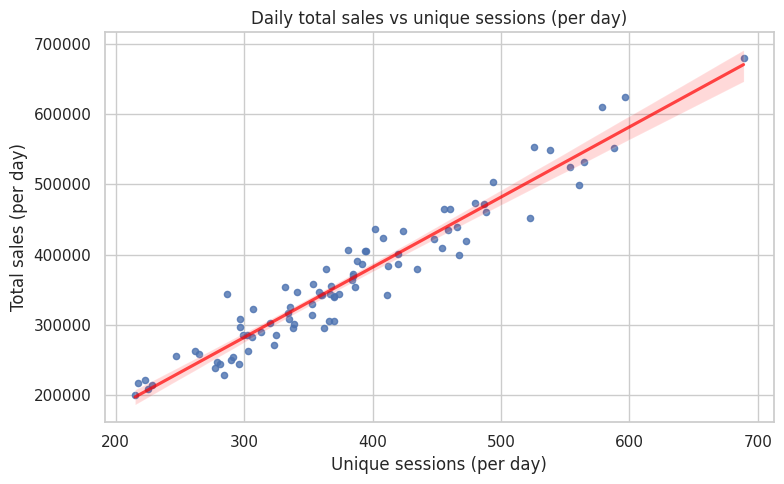


Correlation daily sessions vs total sales:
 Pearson r = 0.9642, p = 2.245e-51
 Spearman rho = 0.9510, p = 1.346e-45

Top-3 continents considered: ['Americas', 'Asia', 'Europe']

Continent correlation results:


,pair,pearson_r,pearson_p,spearman_rho,spearman_p
0,Americas vs Asia,0.692273,8.004063e-14,0.668539,1.100106e-12
1,Americas vs Europe,0.669527,9.911408e-13,0.625885,7.009053e-11
2,Asia vs Europe,0.667786,1.190893e-12,0.608221,3.273138e-10


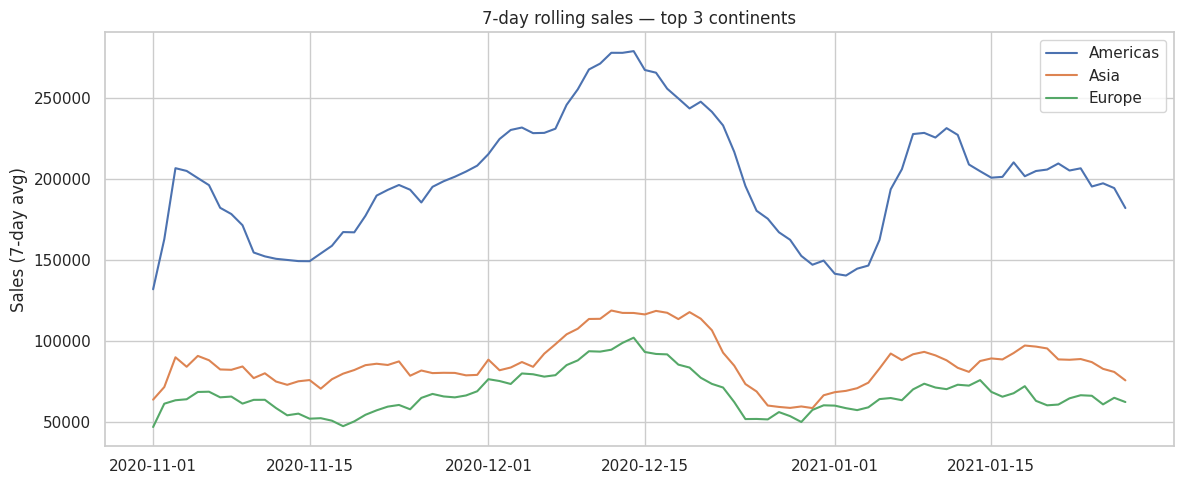


Top traffic channels: ['Organic Search', 'Paid Search', 'Direct', 'Social Search', 'Undefined']


,pair,pearson_r,pearson_p
0,Organic Search vs Paid Search,0.808234,1.755643e-21
1,Organic Search vs Direct,0.759938,9.107881e-18
2,Organic Search vs Social Search,0.434424,2.347593e-05
3,Organic Search vs Undefined,0.435418,2.237821e-05
4,Paid Search vs Direct,0.724343,1.512880e-15
5,Paid Search vs Social Search,0.452287,9.696038e-06
6,Paid Search vs Undefined,0.430021,2.897496e-05
7,Direct vs Social Search,0.461895,5.901047e-06
8,Direct vs Undefined,0.424039,3.838547e-05
9,Social Search vs Undefined,0.359342,5.853111e-04


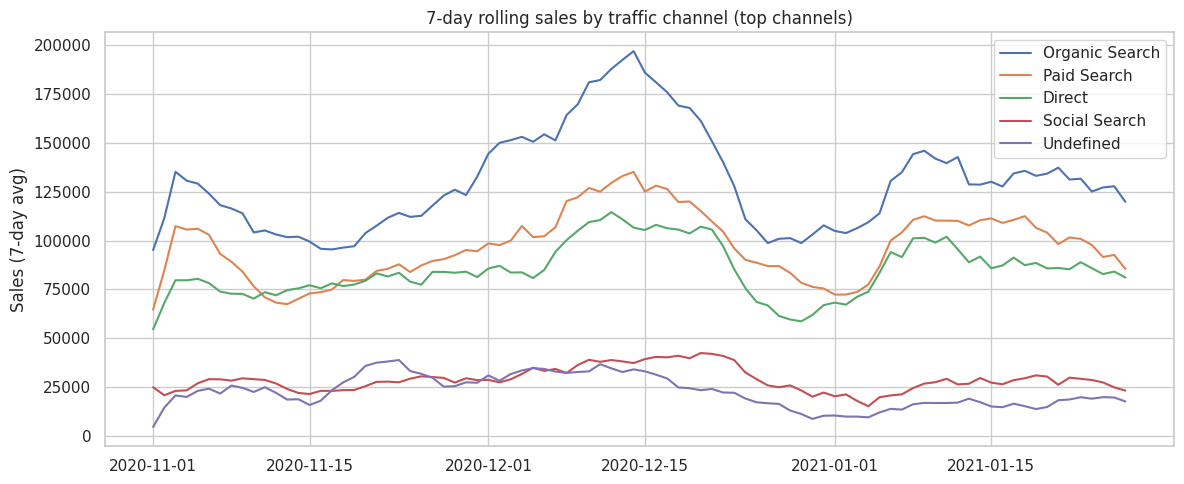


Top-5 categories: ['Sofas & armchairs', 'Chairs', 'Beds', 'Bookcases & shelving units', 'Cabinets & cupboards']


,pair,pearson_r,pearson_p
0,Sofas & armchairs vs Chairs,0.578248,3.638833e-09
1,Sofas & armchairs vs Beds,0.535378,7.687333e-08
2,Sofas & armchairs vs Bookcases & shelving units,0.666194,1.406972e-12
3,Sofas & armchairs vs Cabinets & cupboards,0.657563,3.415056e-12
4,Chairs vs Beds,0.554500,2.079183e-08
5,Chairs vs Bookcases & shelving units,0.637090,2.504550e-11
6,Chairs vs Cabinets & cupboards,0.572870,5.465903e-09
7,Beds vs Bookcases & shelving units,0.592913,1.154998e-09
8,Beds vs Cabinets & cupboards,0.514609,2.910930e-07
9,Bookcases & shelving units vs Cabinets & cupbo...,0.539428,5.867225e-08


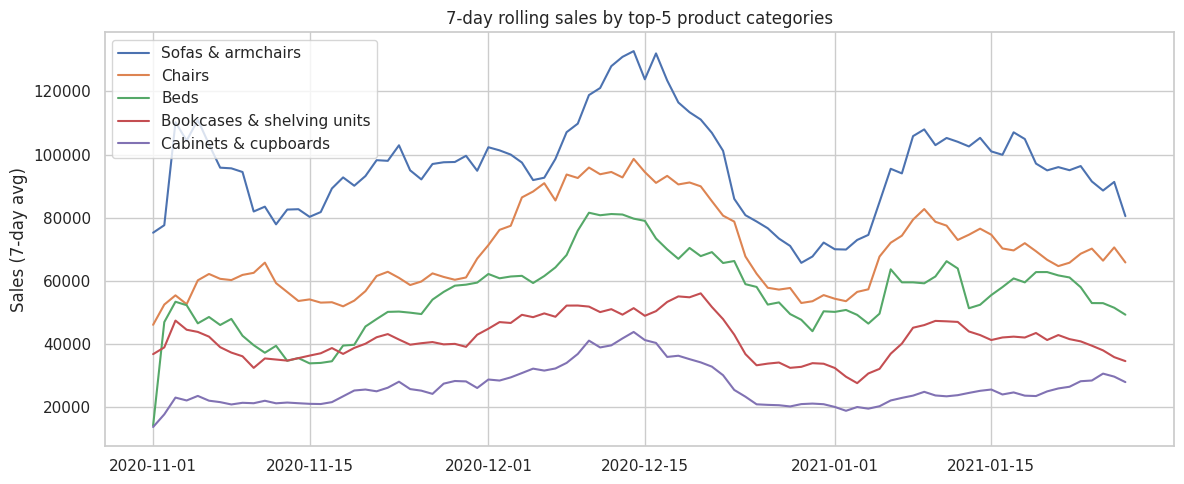


Adjusted p-values (FDR) computed. Samples:


,pair,pearson_r,pearson_p,spearman_rho,spearman_p,pearson_p_adj,significant
0,Americas vs Asia,0.692273,8.004063e-14,0.668539,1.100106e-12,2.401219e-13,True
1,Americas vs Europe,0.669527,9.911408e-13,0.625885,7.009053e-11,1.190893e-12,True
2,Asia vs Europe,0.667786,1.190893e-12,0.608221,3.273138e-10,1.190893e-12,True


,pair,pearson_r,pearson_p,pearson_p_adj,significant
0,Organic Search vs Paid Search,0.808234,1.755643e-21,1.755643e-20,True
1,Organic Search vs Direct,0.759938,9.107881e-18,4.553941e-17,True
2,Organic Search vs Social Search,0.434424,2.347593e-05,3.353704e-05,True
3,Organic Search vs Undefined,0.435418,2.237821e-05,3.353704e-05,True
4,Paid Search vs Direct,0.724343,1.512880e-15,5.042933e-15,True


,pair,pearson_r,pearson_p,pearson_p_adj,significant
0,Sofas & armchairs vs Chairs,0.578248,3.638833e-09,7.277666e-09,True
1,Sofas & armchairs vs Beds,0.535378,7.687333e-08,8.541481e-08,True
2,Sofas & armchairs vs Bookcases & shelving units,0.666194,1.406972e-12,1.406972e-11,True
3,Sofas & armchairs vs Cabinets & cupboards,0.657563,3.415056e-12,1.707528e-11,True
4,Chairs vs Beds,0.554500,2.079183e-08,2.970261e-08,True
5,Chairs vs Bookcases & shelving units,0.637090,2.504550e-11,8.348501e-11,True
6,Chairs vs Cabinets & cupboards,0.572870,5.465903e-09,9.109839e-09,True
7,Beds vs Bookcases & shelving units,0.592913,1.154998e-09,2.887496e-09,True
8,Beds vs Cabinets & cupboards,0.514609,2.910930e-07,2.910930e-07,True
9,Bookcases & shelving units vs Cabinets & cupbo...,0.539428,5.867225e-08,7.334031e-08,True



Correlation between daily avg AOV and sessions: Pearson r = 0.1158, p = 0.2826

Cross-correlation (sessions vs sales) by lag:


,lag,pearson_r,pearson_p
0,-7,0.506906,1.372815e-06
1,-6,0.390681,2.847394e-04
2,-5,0.106050,3.399818e-01
3,-4,-0.004077,9.706409e-01
4,-3,0.133806,2.221376e-01
5,-2,0.347816,1.032918e-03
6,-1,0.682256,3.428964e-13
7,0,0.964242,2.244778e-51
8,1,0.627882,7.561808e-11
9,2,0.278919,9.307013e-03


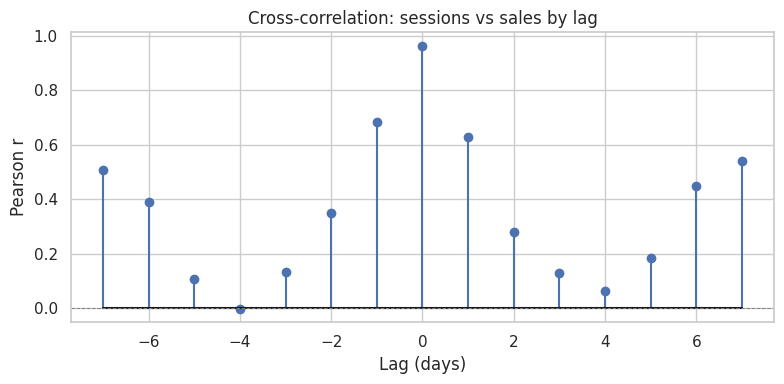


All statistical outputs (CSVs and PNGs) saved to analysis_stats/. Inspect CSVs for exact p-values and adjusted p-values.


In [ ]:
# Full statistical relationships analysis (fixed stem plot)
import pandas as pd, numpy as np, os
import matplotlib.pyplot as plt, seaborn as sns
from scipy import stats
from statsmodels.stats.multitest import multipletests
from IPython.display import display

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10,5)
os.makedirs("analysis_stats", exist_ok=True)

# Load data
df = pd.read_csv("final_analytical_dataset.csv", parse_dates=['order_date'], low_memory=False)
df['price'] = pd.to_numeric(df['price'], errors='coerce')

# Helper: save and show plot
def show_save(fig, fname):
    path = os.path.join("analysis_stats", fname)
    fig.tight_layout()
    fig.savefig(path)
    display(fig)
    plt.close(fig)

# 1) Sessions and total sales per date
daily_sessions = df.groupby(pd.Grouper(key='order_date', freq='D')).agg(
    unique_sessions = ('session_id','nunique'),
    total_sales = ('price','sum')
).reset_index().dropna(subset=['order_date'])
daily_sessions.fillna(0, inplace=True)
daily_sessions.to_csv("analysis_stats/daily_sessions_sales.csv", index=False)

# Scatter plot and regression line
fig, ax = plt.subplots(figsize=(8,5))
sns.regplot(data=daily_sessions, x='unique_sessions', y='total_sales', scatter_kws={'s':20}, line_kws={'color':'red','alpha':0.7}, ax=ax)
ax.set_title("Daily total sales vs unique sessions (per day)")
ax.set_xlabel("Unique sessions (per day)")
ax.set_ylabel("Total sales (per day)")
show_save(fig, "daily_sessions_vs_sales.png")

# Correlations: Pearson and Spearman with p-values
x = daily_sessions['unique_sessions'].values
y = daily_sessions['total_sales'].values

def safe_corr(a,b):
    if np.nanstd(a)==0 or np.nanstd(b)==0:
        return (np.nan, np.nan, np.nan, np.nan)
    r, p = stats.pearsonr(a,b)
    rs, ps = stats.spearmanr(a,b)
    return (r,p, rs, ps)

pear_r, pear_p, spear_r, spear_p = safe_corr(x,y)
print(f"\nCorrelation daily sessions vs total sales:\n Pearson r = {pear_r:.4f}, p = {pear_p:.4g}\n Spearman rho = {spear_r:.4f}, p = {spear_p:.4g}")

# 2) Correlation across top-3 continents
cont_daily = df.groupby([pd.Grouper(key='order_date', freq='D'),'continent'])['price'].sum().unstack(fill_value=0)
cont_total = cont_daily.sum().sort_values(ascending=False)
top3 = cont_total.head(3).index.tolist()
print("\nTop-3 continents considered:", top3)
cont_cor_results = []
for i in range(len(top3)):
    for j in range(i+1,len(top3)):
        a = cont_daily[top3[i]].values
        b = cont_daily[top3[j]].values
        if np.nanstd(a)==0 or np.nanstd(b)==0:
            pear = (np.nan, np.nan)
            spear = (np.nan, np.nan)
        else:
            pear = stats.pearsonr(a,b)
            spear = stats.spearmanr(a,b)
        cont_cor_results.append({
            'pair': f"{top3[i]} vs {top3[j]}",
            'pearson_r': pear[0], 'pearson_p': pear[1],
            'spearman_rho': spear[0], 'spearman_p': spear[1]
        })
cont_cor_df = pd.DataFrame(cont_cor_results)
print("\nContinent correlation results:")
display(cont_cor_df)
cont_cor_df.to_csv("analysis_stats/continent_correlations.csv", index=False)

# Plot top3 continent daily series (7-day rolling)
fig, ax = plt.subplots(figsize=(12,5))
for c in top3:
    series = cont_daily[c].rolling(7, min_periods=1).mean()
    ax.plot(series.index, series.values, label=c)
ax.legend(); ax.set_title("7-day rolling sales — top 3 continents"); ax.set_ylabel("Sales (7-day avg)")
show_save(fig, "top3_continents_rolling7.png")

# 3) Correlation across traffic channels (top channels)
tc_col = 'traffic_channel' if 'traffic_channel' in df.columns else ('traffic_source_info' if 'traffic_source_info' in df.columns else None)
if tc_col:
    tc_daily = df.groupby([pd.Grouper(key='order_date', freq='D'), tc_col])['price'].sum().unstack(fill_value=0)
    top_channels = tc_daily.sum().sort_values(ascending=False).head(6).index.tolist()
    print("\nTop traffic channels:", top_channels)
    tc_pairs = []
    for i in range(len(top_channels)):
        for j in range(i+1,len(top_channels)):
            a = tc_daily[top_channels[i]].values
            b = tc_daily[top_channels[j]].values
            if np.nanstd(a)==0 or np.nanstd(b)==0:
                r,p = (np.nan,np.nan)
            else:
                r,p = stats.pearsonr(a,b)
            tc_pairs.append({'pair':f"{top_channels[i]} vs {top_channels[j]}", 'pearson_r':r, 'pearson_p':p})
    tc_pairs_df = pd.DataFrame(tc_pairs)
    display(tc_pairs_df)
    tc_pairs_df.to_csv("analysis_stats/traffic_channel_pairwise.csv", index=False)
    # plot top channels rolling
    fig, ax = plt.subplots(figsize=(12,5))
    for ch in top_channels:
        ax.plot(tc_daily.index, tc_daily[ch].rolling(7,min_periods=1).mean(), label=ch)
    ax.legend(); ax.set_title("7-day rolling sales by traffic channel (top channels)"); ax.set_ylabel("Sales (7-day avg)")
    show_save(fig, "channels_rolling7.png")
else:
    print("\nNo traffic channel field available for channel correlations.")

# 4) Correlation across top-5 product categories
prod_daily = df.groupby([pd.Grouper(key='order_date', freq='D'),'product_category'])['price'].sum().unstack(fill_value=0)
top5_cats = prod_daily.sum().sort_values(ascending=False).head(5).index.tolist()
print("\nTop-5 categories:", top5_cats)
cat_pairs = []
for i in range(len(top5_cats)):
    for j in range(i+1,len(top5_cats)):
        a = prod_daily[top5_cats[i]].values
        b = prod_daily[top5_cats[j]].values
        if np.nanstd(a)==0 or np.nanstd(b)==0:
            r,p = (np.nan,np.nan)
        else:
            r,p = stats.pearsonr(a,b)
        cat_pairs.append({'pair':f"{top5_cats[i]} vs {top5_cats[j]}", 'pearson_r':r, 'pearson_p':p})
cat_pairs_df = pd.DataFrame(cat_pairs)
display(cat_pairs_df)
cat_pairs_df.to_csv("analysis_stats/category_pairwise.csv", index=False)

# plot top5 categories rolling7
fig, ax = plt.subplots(figsize=(12,5))
for cat in top5_cats:
    ax.plot(prod_daily.index, prod_daily[cat].rolling(7,min_periods=1).mean(), label=cat)
ax.legend(); ax.set_title("7-day rolling sales by top-5 product categories"); ax.set_ylabel("Sales (7-day avg)")
show_save(fig, "top5_categories_rolling7.png")

# Multiple testing correction for p-values where applicable
from statsmodels.stats.multitest import multipletests
def adjust_pvals(df_pairs, pcol='pearson_p', method='fdr_bh'):
    df = df_pairs.copy()
    if df.empty:
        return df
    pvals = df[pcol].fillna(1.0).values
    rej, p_adj, _, _ = multipletests(pvals, method=method)
    df[pcol+'_adj'] = p_adj
    df['significant'] = rej
    return df

cont_cor_df_adj = adjust_pvals(cont_cor_df, 'pearson_p') if not cont_cor_df.empty else cont_cor_df
tc_pairs_df_adj = adjust_pvals(tc_pairs_df, 'pearson_p') if 'tc_pairs_df' in locals() and not tc_pairs_df.empty else pd.DataFrame()
cat_pairs_df_adj = adjust_pvals(cat_pairs_df, 'pearson_p') if not cat_pairs_df.empty else cat_pairs_df

cont_cor_df_adj.to_csv("analysis_stats/continent_correlations_adj.csv", index=False)
if not tc_pairs_df_adj.empty:
    tc_pairs_df_adj.to_csv("analysis_stats/traffic_channel_pairwise_adj.csv", index=False)
cat_pairs_df_adj.to_csv("analysis_stats/category_pairwise_adj.csv", index=False)

print("\nAdjusted p-values (FDR) computed. Samples:")
display(cont_cor_df_adj)
if not tc_pairs_df_adj.empty:
    display(tc_pairs_df_adj.head())
display(cat_pairs_df_adj)

# Additional relationship checks
# A) Correlation between AOV (per session) and sessions per day
session_sales = df.groupby('session_id').agg(session_sales=('price','sum'), session_date=('order_date','min')).reset_index()
daily_aov = session_sales.groupby(pd.Grouper(key='session_date', freq='D')).agg(
    avg_aov=('session_sales','mean'),
    sessions=('session_id','nunique')
).dropna()
r_aov, p_aov = (np.nan, np.nan) if np.nanstd(daily_aov['avg_aov'])==0 or np.nanstd(daily_aov['sessions'])==0 else stats.pearsonr(daily_aov['avg_aov'], daily_aov['sessions'])
print(f"\nCorrelation between daily avg AOV and sessions: Pearson r = {r_aov:.4f}, p = {p_aov:.4g}")

# B) Cross-correlation: sessions vs sales (lagged)
max_lag = 7
cc_results = []
s = daily_sessions.set_index('order_date')['unique_sessions'].fillna(0)
t = daily_sessions.set_index('order_date')['total_sales'].fillna(0)
for lag in range(-max_lag, max_lag+1):
    if lag < 0:
        a = s.shift(-lag).values
        b = t.values
    else:
        a = s.values
        b = t.shift(lag).values
    valid = (~np.isnan(a)) & (~np.isnan(b))
    if valid.sum() < 3 or np.nanstd(a[valid])==0 or np.nanstd(b[valid])==0:
        cc_results.append({'lag':lag, 'pearson_r':np.nan, 'pearson_p':np.nan})
    else:
        r,p = stats.pearsonr(a[valid], b[valid])
        cc_results.append({'lag':lag, 'pearson_r':r, 'pearson_p':p})
cc_df = pd.DataFrame(cc_results)
cc_df.to_csv("analysis_stats/crosscorr_sessions_sales.csv", index=False)
print("\nCross-correlation (sessions vs sales) by lag:")
display(cc_df)

# Plot cross-correlation using supported stem call (no use_line_collection)
fig, ax = plt.subplots(figsize=(8,4))
markerline, stemlines, baseline = ax.stem(cc_df["lag"], cc_df["pearson_r"], linefmt='C0-', markerfmt='C0o', basefmt="k-")
ax.set_xlabel("Lag (days)")
ax.set_ylabel("Pearson r")
ax.set_title("Cross-correlation: sessions vs sales by lag")
ax.axhline(0, color='gray', linewidth=0.7, linestyle='--')
show_save(fig, "crosscorr_sessions_sales.png")



### Daily sessions vs total sales

Daily unique sessions and daily total sales are very strongly correlated (Pearson r = 0.964, p < 1e-50; Spearman rho = 0.951, p < 1e-44). This indicates that days with more sessions reliably produce higher revenue. The relationship is large in magnitude and highly statistically significant, so increases in traffic volume are the primary driver of daily revenue swings. Recommendation: prioritize actions that increase qualified sessions (top-of-funnel marketing, SEO, paid acquisition) and monitor session quality to avoid low-conversion traffic.

---

### Cross-correlation (lagged relationship between sessions and sales)

Cross-correlation shows the strongest association at lag 0 (r = 0.964) and at short positive and negative lags (e.g., lag −1 r = 0.682; lag +1 r = 0.628). This pattern means sessions and sales move together on the same day, with some evidence that sessions on adjacent days are also related to sales (possible short-term carryover). There is no clear multi-day lead or lag suggesting a systematic delay; marketing and traffic typically convert within the same day or very near it. Recommendation: prioritize same-day campaign measurement and short windows for attribution.

---

### Correlations across top-3 continents

Daily sales between the Americas, Asia, and Europe are positively correlated (pairwise Pearson r ≈ 0.67–0.69, all p-values ≪ 0.001 after FDR adjustment). These moderate-to-strong correlations suggest that global drivers (sitewide promotions, seasonality, or universal demand cycles) influence sales across regions; however, the correlations are below 1, indicating region-specific variation remains. Recommendation: investigate dates of major campaigns or global events behind synchronized peaks, and run region-level analyses to identify local drivers that deviate from global trends.

---

### Correlations across top traffic channels

Top traffic channels (Organic Search, Paid Search, Direct, Social Search, Undefined) show mostly strong positive correlations pairwise (Pearson r frequently ≥ 0.43, many r > 0.7) with highly significant p-values after adjustment. This implies channels often rise and fall together (e.g., overall traffic volume or seasonality affecting all channels) though some channels (social, undefined) correlate less strongly than paid vs organic. Recommendation: examine whether channel spikes are campaign-driven (paid) or organic seasonality; avoid treating channels in isolation when planning capacity or promotions.

---

### Correlations across top-5 product categories

Top categories (Sofas & armchairs, Chairs, Beds, Bookcases & shelving units, Cabinets & cupboards) show moderate positive pairwise correlations (Pearson r ≈ 0.51–0.67), all statistically significant after FDR correction. This indicates category sales tend to move together (common demand cycles or cross-category promotions), though correlations are not perfect — category-specific factors still matter. Recommendation: coordinate merchandising and promotions across top categories while also testing category-specific price or creative variants.

---

### AOV vs sessions

Daily average order value (AOV) shows a weak, non-significant correlation with daily sessions (Pearson r = 0.116, p ≈ 0.28). This suggests busier days are not systematically higher or lower in AOV; traffic volume and order value appear largely independent at the daily level. Recommendation: optimize both traffic volume and on-site conversion/AOV improvements separately (e.g., upsell/checkout optimization) rather than assuming more sessions will change AOV.

---

### Statistical significance and multiple testing

All major pairwise correlation tests reported very small p-values; after FDR adjustment, continent, channel, and category pairwise correlations remain statistically significant. This confirms the correlations are unlikely to be due to chance. Recommendation: interpret effect sizes (Pearson r) for business meaning, not p-values alone — strong r (e.g., >0.6) implies practically useful synchronization; moderate r (≈0.4–0.6) suggests partial coupling.

---

### Practical takeaways

- Traffic volume is the dominant lever for revenue; campaigns that increase qualified sessions reliably raise sales.  
- Global events and promotions appear to drive simultaneous increases across continents and channels; align global and local planning.  
- Channel correlations mean that attribution and capacity planning should consider multi-channel effects rather than single-channel metrics alone.  
- Category sales move together but still allow room for targeted category tactics.  
- AOV behaves independently of daily sessions; invest in dedicated AOV experiments (pricing, bundles, cross-sell).  
- Use short attribution windows (same-day or ±1 day) for campaign evaluation given the quick session → sales relationship.



Samples prepared: daily_by_group head:


is_registered,unregistered_sales,registered_sales
session_date,,
2020-11-01,222745.5,21547.0
2020-11-02,310550.0,44956.8
2020-11-03,469829.1,29150.5
2020-11-04,318204.9,20982.2
2020-11-05,365942.0,25334.6


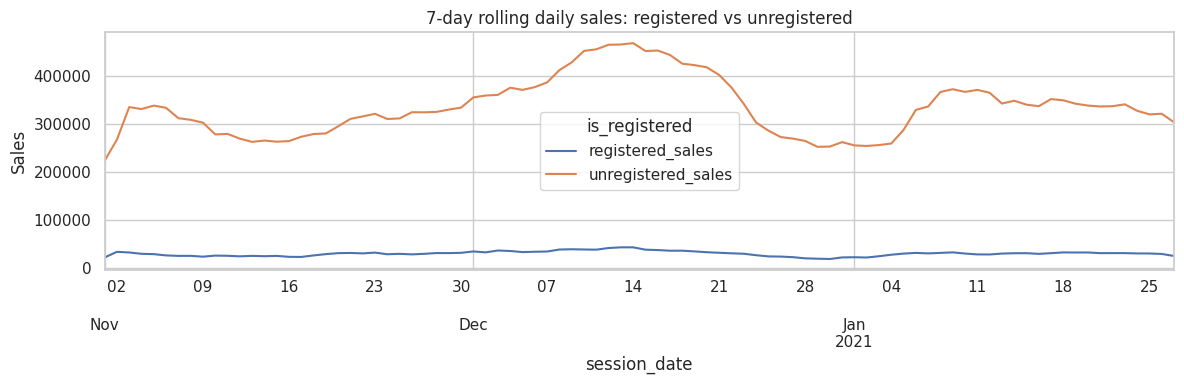

Shapiro registered_sales: W=0.9592, p=0.007295
Shapiro unregistered_sales: W=0.9522, p=0.002618

Levene test for equal variances: stat=86.9893, p=4.971e-17

Mann-Whitney U test (registered vs unregistered daily sales): U=0.0000, p=2.216e-30
Welch t-test (registered vs unregistered daily sales): t=-30.5522, p=4.491e-49
Bootstrap mean(registered - unregistered) = -304355.26, 95% CI = [-325167.61, -285872.52]

Conclusion for sales per date (registered vs unregistered):
- Mann-Whitney U indicates a statistically significant difference (p=2.216e-30).
- Welch t-test p=4.491e-49. Bootstrap mean diff and 95% CI shown above.

Sessions per traffic channel (top 10):


,session_id
traffic_channel,
Organic Search,11921
Paid Search,9042
Direct,7800
Social Search,2716
Undefined,2059



Testing Kruskal-Wallis across top channels: ['Organic Search', 'Paid Search', 'Direct', 'Social Search', 'Undefined']
Kruskal-Wallis H=2.7766, p=0.5959
Kruskal-Wallis not significant; no strong evidence of differences between channels' session_sales distributions.

Organic session counts by continent:


,organic_count,n
continent,,
Americas,6536,18553
Europe,2238,6261



Proportion test Europe vs Americas: prop_Europe=0.3575, prop_Americas=0.3523
Z=0.7389, p=0.46
- No statistically significant difference in organic session proportions between Europe and Americas.

Contingency table device vs bought (partial view):


bought,True
device,
desktop,19702
mobile,13113
tablet,723


Chi-square test: chi2=0.0000, p=1, dof=0
- No evidence to reject independence between device and purchase occurrence.

Cliff's delta (registered vs unregistered daily sales) = -1.0000 (large)


In [ ]:
# Statistical analysis of group differences
import pandas as pd, numpy as np, os
import matplotlib.pyplot as plt, seaborn as sns
from scipy import stats
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.multitest import multipletests

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10,5)
os.makedirs("stats_tests_outputs", exist_ok=True)

# Load data
df = pd.read_csv("final_analytical_dataset.csv", parse_dates=['order_date'], low_memory=False)
df['price'] = pd.to_numeric(df['price'], errors='coerce').fillna(0.0)

# Create flags
df['is_registered'] = df['registered_user_id'].notna()
df['is_purchase'] = df['price'] > 0

# 1) Sales per date: registered vs unregistered
# Aggregate daily total sales separately for registered and unregistered sessions
daily = df.copy()
daily['session_user_key'] = daily['session_id']  # sessions may repeat rows
# Sum price per session, take session date
session_level = daily.groupby(['session_id','is_registered']).agg(
    session_sales = ('price','sum'),
    session_date = ('order_date','min')
).reset_index()
# Aggregate to daily totals by registration group
daily_by_group = session_level.groupby([pd.Grouper(key='session_date', freq='D'),'is_registered']).agg(
    total_sales = ('session_sales','sum'),
    session_count = ('session_id','nunique')
).reset_index().pivot(index='session_date', columns='is_registered', values='total_sales').fillna(0)
daily_by_group.columns = ['unregistered_sales','registered_sales'] if (False) else (daily_by_group.columns.map({False:'unregistered_sales', True:'registered_sales'}))
daily_by_group = daily_by_group.sort_index()

print("Samples prepared: daily_by_group head:")
display(daily_by_group.head())

# Quick visualization
fig, ax = plt.subplots(1,1,figsize=(12,4))
daily_by_group[['registered_sales','unregistered_sales']].rolling(7, min_periods=1).mean().plot(ax=ax)
ax.set_title("7-day rolling daily sales: registered vs unregistered")
ax.set_ylabel("Sales")
plt.tight_layout()
plt.show()

# Normality tests (Shapiro) on the two samples (use sample of daily totals)
r_sample = daily_by_group['registered_sales'].values
u_sample = daily_by_group['unregistered_sales'].values

def try_shapiro(arr, name):
    arr = arr[~np.isnan(arr)]
    if len(arr) < 3:
        print(f"Shapiro for {name}: not enough data (n={len(arr)})")
        return None
    try:
        stat, p = stats.shapiro(arr)
        print(f"Shapiro {name}: W={stat:.4f}, p={p:.4g}")
    except Exception as e:
        print(f"Shapiro {name} error: {e}")

try_shapiro(r_sample, "registered_sales")
try_shapiro(u_sample, "unregistered_sales")

# Equality of variances: Levene test
lev_stat, lev_p = stats.levene(r_sample, u_sample, center='median')
print(f"\nLevene test for equal variances: stat={lev_stat:.4f}, p={lev_p:.4g}")

# Choose test: data usually non-normal and heteroskedastic -> Mann-Whitney U (nonparametric)
mw_stat, mw_p = stats.mannwhitneyu(r_sample, u_sample, alternative='two-sided')
print(f"\nMann-Whitney U test (registered vs unregistered daily sales): U={mw_stat:.4f}, p={mw_p:.4g}")

# Two-sample t-test with Welch correction (for reference)
t_stat, t_p = stats.ttest_ind(r_sample, u_sample, equal_var=False, nan_policy='omit')
print(f"Welch t-test (registered vs unregistered daily sales): t={t_stat:.4f}, p={t_p:.4g}")

# Bootstrap for mean difference (robust estimate and CI)
def bootstrap_mean_diff(a, b, n_boot=10000, seed=42):
    rng = np.random.default_rng(seed)
    diffs = []
    a = np.array(a); b = np.array(b)
    for _ in range(n_boot):
        samp_a = rng.choice(a, size=len(a), replace=True)
        samp_b = rng.choice(b, size=len(b), replace=True)
        diffs.append(samp_a.mean() - samp_b.mean())
    diffs = np.array(diffs)
    return diffs.mean(), np.percentile(diffs, [2.5,97.5])

mean_diff, ci = bootstrap_mean_diff(r_sample, u_sample, n_boot=2000)
print(f"Bootstrap mean(registered - unregistered) = {mean_diff:.2f}, 95% CI = [{ci[0]:.2f}, {ci[1]:.2f}]")

# Conclusions to print
print("\nConclusion for sales per date (registered vs unregistered):")
if mw_p < 0.05:
    print(f"- Mann-Whitney U indicates a statistically significant difference (p={mw_p:.4g}).")
else:
    print(f"- Mann-Whitney U indicates no statistically significant difference (p={mw_p:.4g}).")
print(f"- Welch t-test p={t_p:.4g}. Bootstrap mean diff and 95% CI shown above.")

# 2) Number of sessions by traffic channels: compare groups
tc_col = 'traffic_channel' if 'traffic_channel' in df.columns else ('traffic_source_info' if 'traffic_source_info' in df.columns else None)
if tc_col:
    # Count sessions per channel (unique sessions). Use session-level dedup
    sess_channels = df[['session_id', tc_col]].dropna(subset=[tc_col]).drop_duplicates()
    counts_by_channel = sess_channels.groupby(tc_col)['session_id'].nunique().sort_values(ascending=False)
    print("\nSessions per traffic channel (top 10):")
    display(counts_by_channel.head(10))

    sess_sales = df.groupby(['session_id', tc_col]).agg(session_sales=('price','sum')).reset_index()
    top_channels = counts_by_channel.head(6).index.tolist()
    groups = [sess_sales[sess_sales[tc_col]==ch]['session_sales'].values for ch in top_channels]
    print(f"\nTesting Kruskal-Wallis across top channels: {top_channels}")
    kw_stat, kw_p = stats.kruskal(*groups)
    print(f"Kruskal-Wallis H={kw_stat:.4f}, p={kw_p:.4g}")

    # If KW significant, do pairwise Mann-Whitney with FDR correction
    if kw_p < 0.05:
        pairs = []
        pvals = []
        names = []
        for i in range(len(top_channels)):
            for j in range(i+1, len(top_channels)):
                a = groups[i]; b = groups[j]
                if len(a) < 3 or len(b) < 3:
                    p = np.nan
                else:
                    _, p = stats.mannwhitneyu(a, b, alternative='two-sided')
                pairs.append((top_channels[i], top_channels[j]))
                pvals.append(p if not np.isnan(p) else 1.0)
                names.append(f"{top_channels[i]} vs {top_channels[j]}")
        rej, p_adj, _, _ = multipletests(pvals, method='fdr_bh')
        print("\nPairwise Mann-Whitney (FDR-adjusted):")
        for k,(pair,p0) in enumerate(zip(pairs,p_adj)):
            print(f"{pair[0]} vs {pair[1]}: adj-p={p0:.4g}, significant={rej[k]}")
    else:
        print("Kruskal-Wallis not significant; no strong evidence of differences between channels' session_sales distributions.")
else:
    print("\nTraffic channel data not available; skipping channel session tests.")

# 3) Proportion of sessions with organic traffic: Europe vs Americas
# Build session-level traffic channel and continent (one row per session)
sess_info = df[['session_id','country','continent','traffic_source_info','traffic_channel']].drop_duplicates(subset=['session_id']).copy()
# pick traffic channel preferentially traffic_channel then traffic_source_info
if 'traffic_channel' in sess_info.columns:
    sess_info['channel'] = sess_info['traffic_channel'].fillna(sess_info['traffic_source_info'])
else:
    sess_info['channel'] = sess_info['traffic_source_info']

# Filter sessions in Europe and Americas and exclude missing continent
sess_info = sess_info[sess_info['continent'].isin(['Europe','Americas'])]
# define organic indicator (case-insensitive)
sess_info['is_organic'] = sess_info['channel'].fillna('').str.lower().str.contains('organic')

# Count successes and n for each continent
counts = sess_info.groupby('continent')['is_organic'].agg(['sum','count']).rename(columns={'sum':'organic_count','count':'n'})
print("\nOrganic session counts by continent:")
display(counts)

# Two-proportion z-test (Europe vs Americas)
if 'Europe' in counts.index and 'Americas' in counts.index:
    success = np.array([counts.loc['Europe','organic_count'], counts.loc['Americas','organic_count']])
    nobs = np.array([counts.loc['Europe','n'], counts.loc['Americas','n']])
    stat, pval = proportions_ztest(success, nobs, alternative='two-sided')
    prop_eu = success[0]/nobs[0]
    prop_am = success[1]/nobs[1]
    print(f"\nProportion test Europe vs Americas: prop_Europe={prop_eu:.4f}, prop_Americas={prop_am:.4f}")
    print(f"Z={stat:.4f}, p={pval:.4g}")
    if pval < 0.05:
        print("- The proportion of organic sessions differs significantly between Europe and Americas.")
    else:
        print("- No statistically significant difference in organic session proportions between Europe and Americas.")
else:
    print("\nInsufficient continent data for proportion test (Europe/Americas).")

# Additional tests

# 4) Chi-square test: association between device type and having a purchase (session-level)
if 'device' in df.columns:
    sess_device = df.groupby(['session_id','device']).agg(session_sales=('price','sum')).reset_index()
    sess_device['bought'] = sess_device['session_sales']>0
    cont_table = pd.crosstab(sess_device['device'], sess_device['bought'])
    print("\nContingency table device vs bought (partial view):")
    display(cont_table.head())
    try:
        chi2, chi_p, dof, exp = stats.chi2_contingency(cont_table)
        print(f"Chi-square test: chi2={chi2:.4f}, p={chi_p:.4g}, dof={dof}")
        if chi_p < 0.05:
            print("- Device and purchase occurrence are associated (reject independence).")
        else:
            print("- No evidence to reject independence between device and purchase occurrence.")
    except Exception as e:
        print("Chi-square test error:", e)
else:
    print("\nDevice column missing; skipping chi-square test.")

# 5) Levene test already computed above for registered vs unregistered variance equality (printed earlier)
# 6) Effect size reporting: Cliff's delta for registered vs unregistered daily sales (nonparametric effect size)
def cliffs_delta(a,b):
    # returns delta and magnitude descriptor
    a = np.array(a); b = np.array(b)
    n1 = len(a); n2 = len(b)
    gt = 0; lt = 0
    for x in a:
        gt += np.sum(x > b)
        lt += np.sum(x < b)
    delta = (gt - lt) / (n1*n2)
    # magnitude
    mag = 'negligible'
    absd = abs(delta)
    if absd >= 0.474:
        mag = 'large'
    elif absd >= 0.33:
        mag = 'medium'
    elif absd >= 0.147:
        mag = 'small'
    return delta, mag

delta, mag = cliffs_delta(r_sample, u_sample)
print(f"\nCliff's delta (registered vs unregistered daily sales) = {delta:.4f} ({mag})")



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:

daily_sessions.to_csv("daily_sessions_sales.csv", index=False)
sales.to_csv("sales_detail.csv", index=False)
pivot_cat_country.to_csv("sales_top10cats_top5countries.csv", index=True)

/tmp/ipython-input-848744499.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cont_sales.values, y=cont_sales.index, palette="Blues_r")


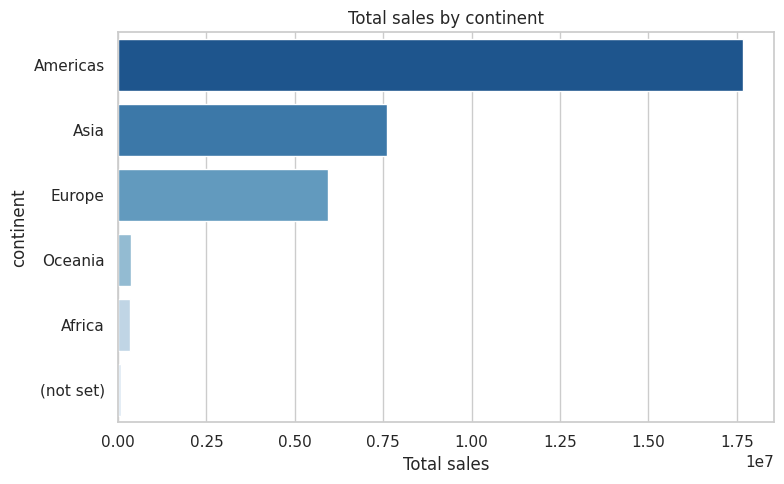

/tmp/ipython-input-848744499.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cont_orders.values, y=cont_orders.index, palette="Greens_r")


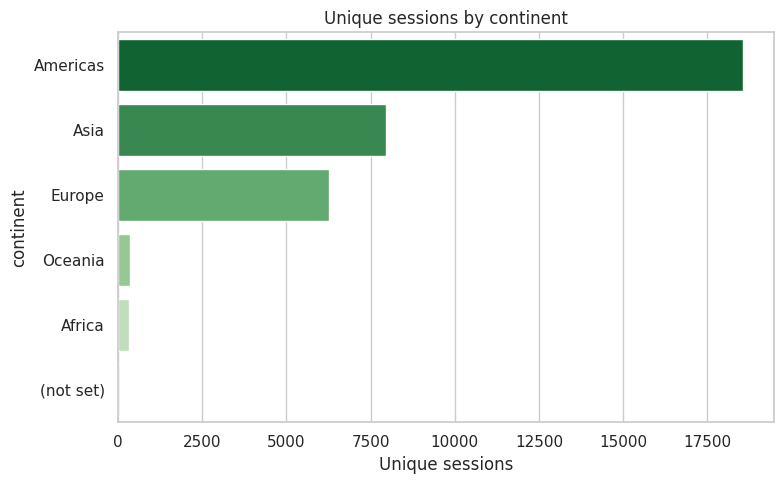

/tmp/ipython-input-848744499.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=country_sales.values, y=country_sales.index, palette="magma")


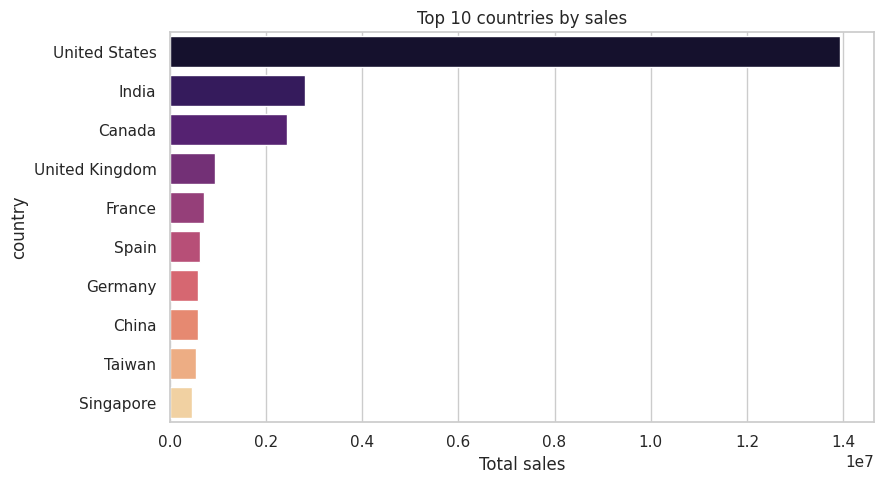

/tmp/ipython-input-848744499.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cat_sales.values, y=cat_sales.index, palette="viridis")


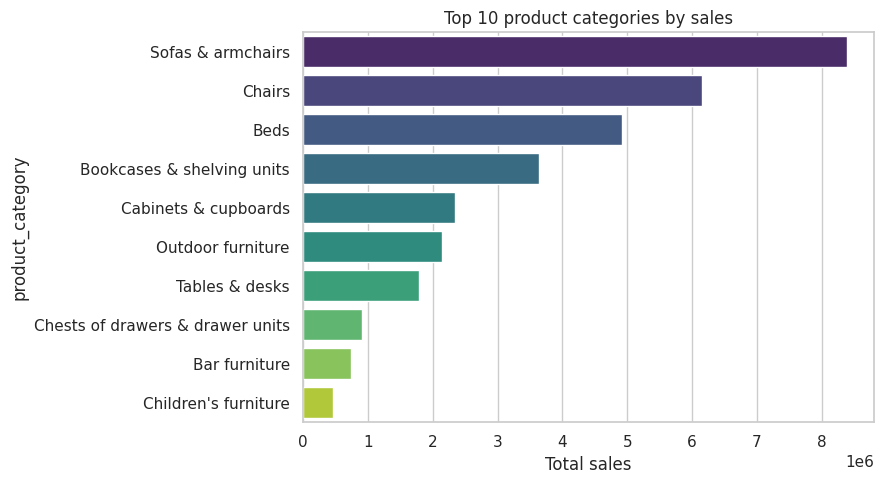

/tmp/ipython-input-848744499.py:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_pareto_plot, x='product_category', y='sales', ax=ax1, palette="pastel")
/tmp/ipython-input-848744499.py:58: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)


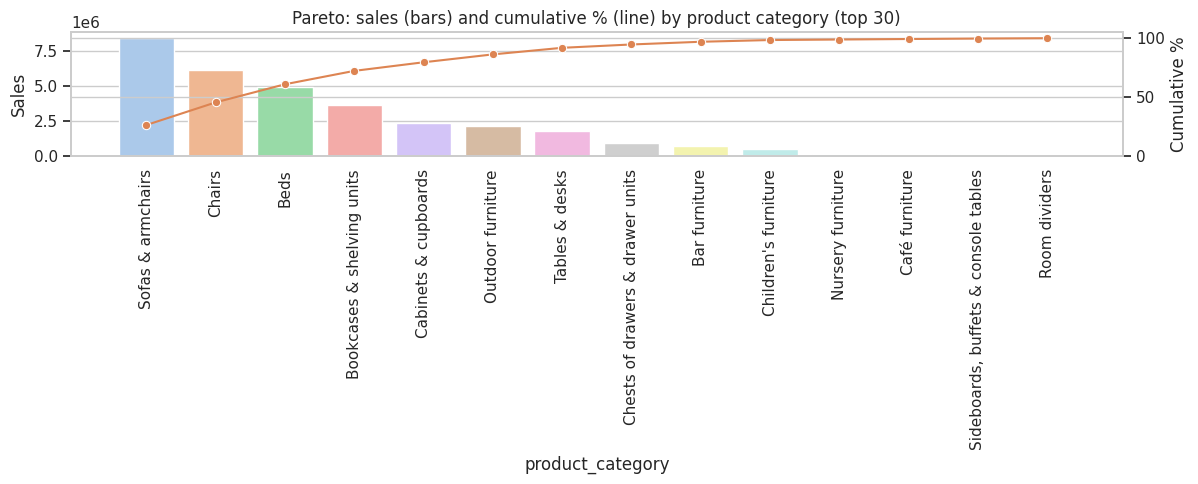

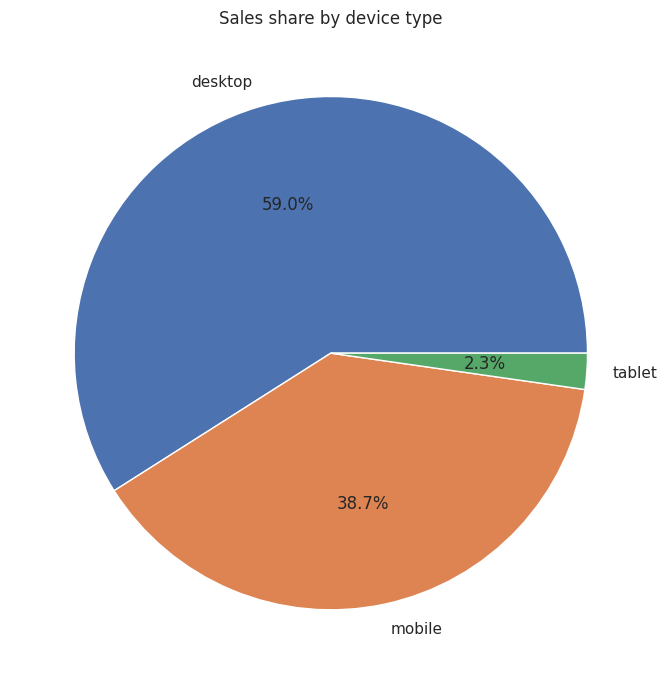

/tmp/ipython-input-848744499.py:79: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=model_sales.values, y=model_sales.index, palette="coolwarm")


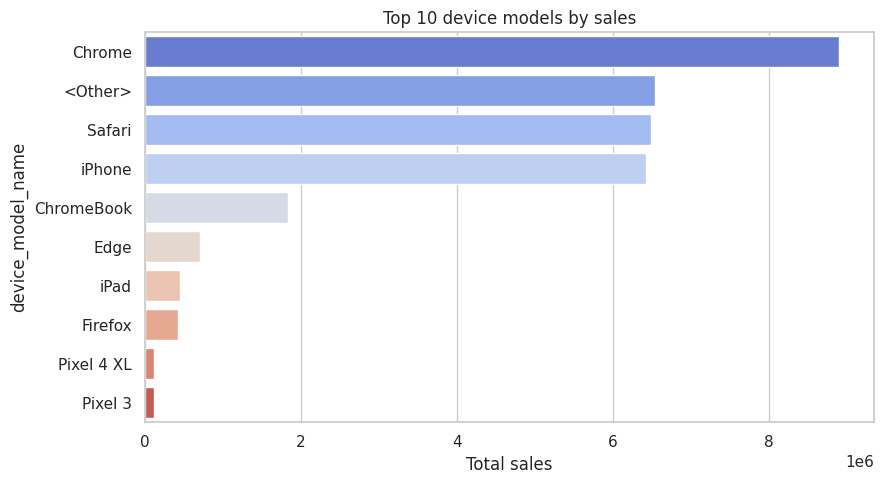

/tmp/ipython-input-848744499.py:88: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=traffic_sales.values, y=traffic_sales.index, palette="cubehelix")


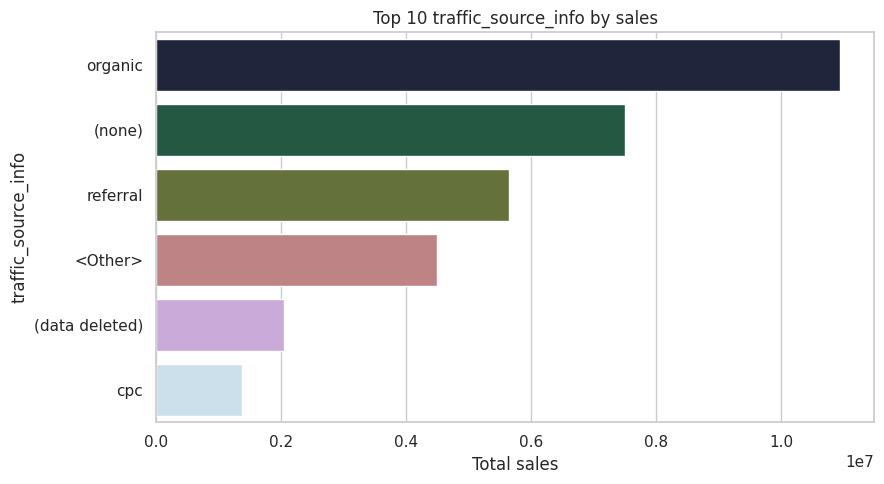

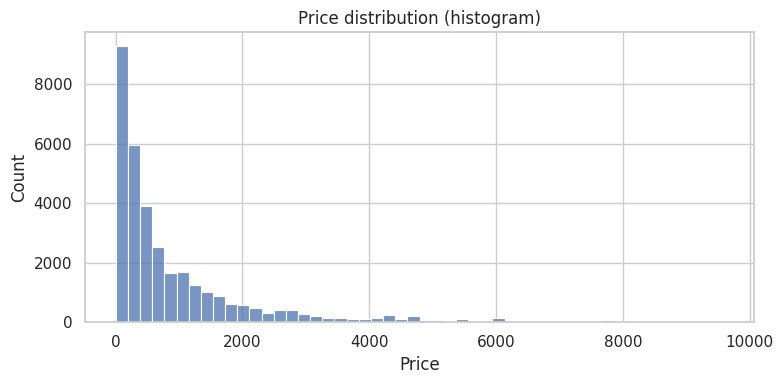

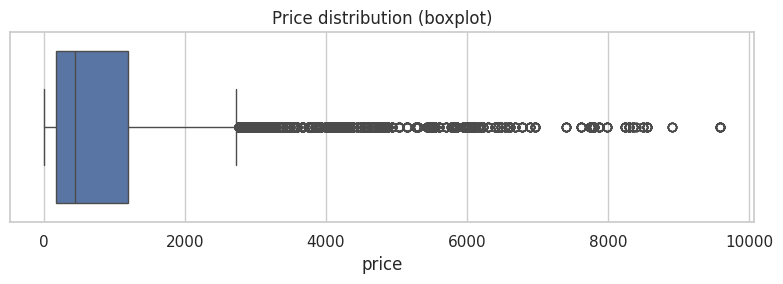

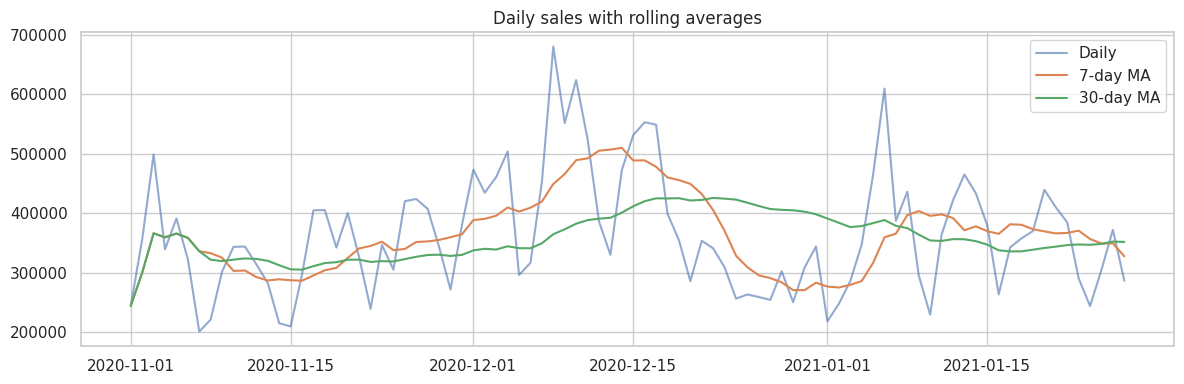

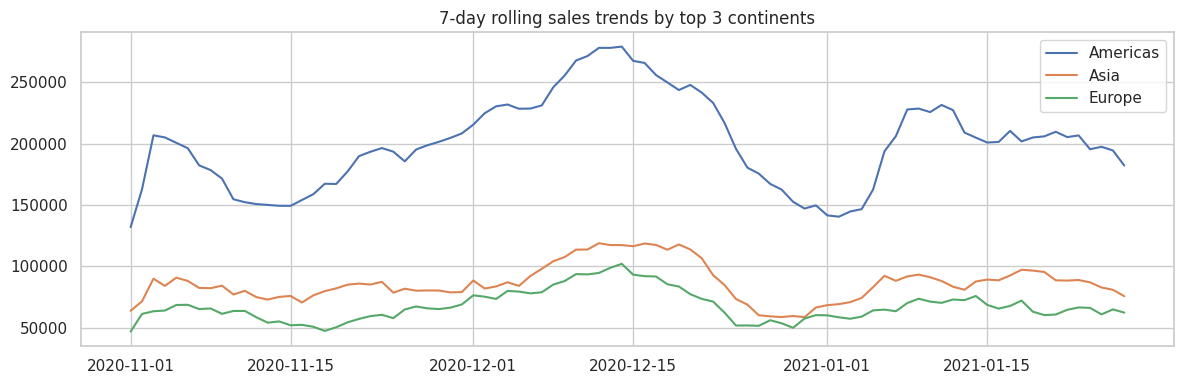

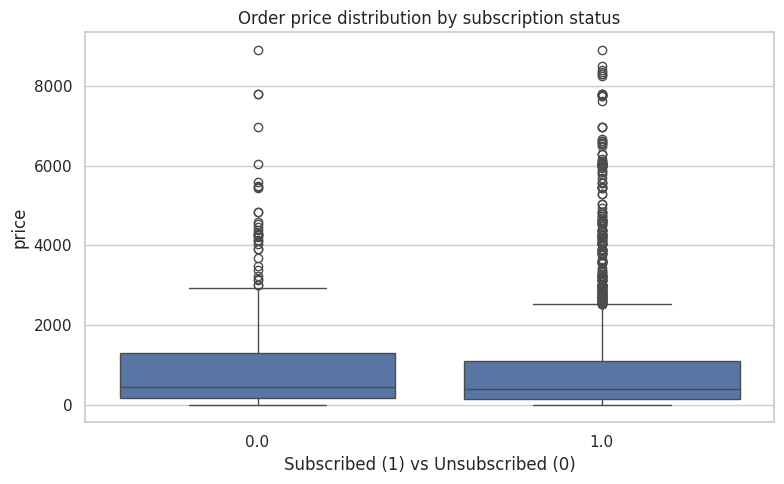

/tmp/ipython-input-848744499.py:140: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=regs.values, y=regs.index, palette="viridis")


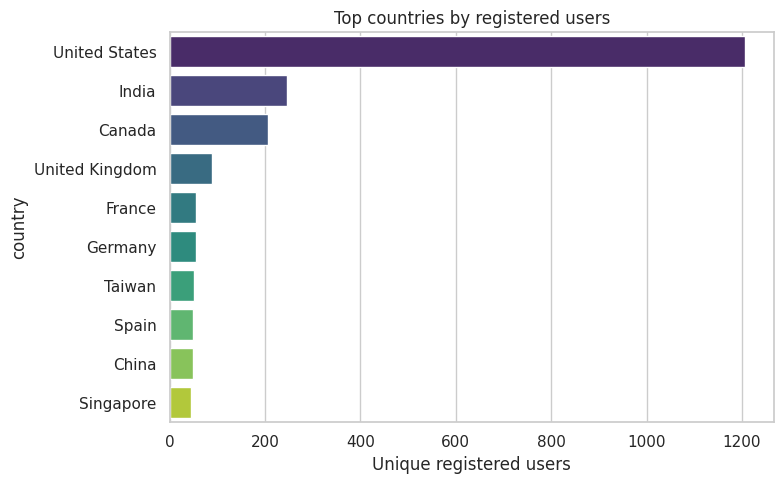

All visuals displayed inline and saved to analysis_visuals/


In [ ]:
# Visualization cell that shows charts inline and saves them
import pandas as pd, numpy as np, os
import matplotlib.pyplot as plt, seaborn as sns
from IPython.display import display

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10,6)
os.makedirs("analysis_visuals", exist_ok=True)

# Load dataset
df = pd.read_csv("final_analytical_dataset.csv", parse_dates=['order_date'], low_memory=False)
df['price'] = pd.to_numeric(df['price'], errors='coerce').fillna(0.0)
sales = df[df['price']>0].copy()

def save_and_display(fig, fname):
    path = os.path.join("analysis_visuals", fname)
    fig.tight_layout()
    fig.savefig(path)
    display(fig)
    plt.close(fig)

# 1. Sales by continent (bar)
cont_sales = sales.groupby('continent')['price'].sum().sort_values(ascending=False)
fig = plt.figure(figsize=(8,5))
sns.barplot(x=cont_sales.values, y=cont_sales.index, palette="Blues_r")
plt.xlabel("Total sales"); plt.title("Total sales by continent")
save_and_display(fig, "sales_by_continent.png")

# 2. Unique sessions by continent (bar)
cont_orders = df.groupby('continent')['session_id'].nunique().sort_values(ascending=False)
fig = plt.figure(figsize=(8,5))
sns.barplot(x=cont_orders.values, y=cont_orders.index, palette="Greens_r")
plt.xlabel("Unique sessions"); plt.title("Unique sessions by continent")
save_and_display(fig, "sessions_by_continent.png")

# 3. Top 10 countries by sales (bar)
country_sales = sales.groupby('country')['price'].sum().sort_values(ascending=False).head(10)
fig = plt.figure(figsize=(9,5))
sns.barplot(x=country_sales.values, y=country_sales.index, palette="magma")
plt.xlabel("Total sales"); plt.title("Top 10 countries by sales")
save_and_display(fig, "top10_countries_sales.png")

# 4. Top 10 product categories (bar)
cat_sales = sales.groupby('product_category')['price'].sum().sort_values(ascending=False).head(10)
fig = plt.figure(figsize=(9,5))
sns.barplot(x=cat_sales.values, y=cat_sales.index, palette="viridis")
plt.xlabel("Total sales"); plt.title("Top 10 product categories by sales")
save_and_display(fig, "top10_categories.png")

# 5. Pareto combined chart for top categories
cat_all = sales.groupby('product_category')['price'].sum().sort_values(ascending=False)
df_pareto = cat_all.reset_index().rename(columns={0:'sales', 'product_category':'product_category'})
df_pareto['sales'] = cat_all.values
df_pareto['cum_pct'] = df_pareto['sales'].cumsum() / df_pareto['sales'].sum() * 100
df_pareto_plot = df_pareto.head(30)
fig, ax1 = plt.subplots(figsize=(12,5))
sns.barplot(data=df_pareto_plot, x='product_category', y='sales', ax=ax1, palette="pastel")
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
ax1.set_ylabel("Sales")
ax2 = ax1.twinx()
sns.lineplot(data=df_pareto_plot, x='product_category', y='cum_pct', marker='o', color='C1', ax=ax2)
ax2.set_ylabel("Cumulative %")
ax2.set_ylim(0, 105)
plt.title("Pareto: sales (bars) and cumulative % (line) by product category (top 30)")
save_and_display(fig, "pareto_categories_top30.png")

# 6. Device share pie
if 'device' in sales.columns:
    device_sales = sales.groupby('device')['price'].sum().sort_values(ascending=False)
    fig = plt.figure(figsize=(7,7))
    device_sales.plot(kind='pie', autopct='%1.1f%%', legend=False)
    plt.ylabel(''); plt.title("Sales share by device type")
    save_and_display(fig, "device_share_pie.png")

# 7. Top 10 device models (horizontal)
if 'device_model_name' in sales.columns:
    model_sales = sales.groupby('device_model_name')['price'].sum().sort_values(ascending=False).head(10)
    fig = plt.figure(figsize=(9,5))
    sns.barplot(x=model_sales.values, y=model_sales.index, palette="coolwarm")
    plt.xlabel("Total sales"); plt.title("Top 10 device models by sales")
    save_and_display(fig, "top10_device_models.png")

# 8. Top traffic sources (bar)
traffic_col = 'traffic_source_info' if 'traffic_source_info' in sales.columns else ('traffic_channel' if 'traffic_channel' in sales.columns else None)
if traffic_col:
    traffic_sales = sales.groupby(traffic_col)['price'].sum().sort_values(ascending=False).head(10)
    fig = plt.figure(figsize=(9,5))
    sns.barplot(x=traffic_sales.values, y=traffic_sales.index, palette="cubehelix")
    plt.xlabel("Total sales"); plt.title(f"Top 10 {traffic_col} by sales")
    save_and_display(fig, f"top10_{traffic_col}_sales.png")

# 9. Price distribution + boxplot
fig = plt.figure(figsize=(8,4))
sns.histplot(sales['price'], bins=50, kde=False)
plt.xlabel("Price"); plt.title("Price distribution (histogram)")
save_and_display(fig, "price_histogram.png")

fig = plt.figure(figsize=(8,3))
sns.boxplot(x=sales['price'])
plt.title("Price distribution (boxplot)")
save_and_display(fig, "price_boxplot.png")

# 10. Daily sales with rolling averages
if 'order_date' in sales.columns and sales['order_date'].notnull().any():
    daily = sales.groupby(pd.Grouper(key='order_date', freq='D'))['price'].sum().reset_index()
    daily['r7'] = daily['price'].rolling(7, min_periods=1).mean()
    daily['r30'] = daily['price'].rolling(30, min_periods=1).mean()
    fig = plt.figure(figsize=(12,4))
    plt.plot(daily['order_date'], daily['price'], label='Daily', alpha=0.6)
    plt.plot(daily['order_date'], daily['r7'], label='7-day MA')
    plt.plot(daily['order_date'], daily['r30'], label='30-day MA')
    plt.legend(); plt.title("Daily sales with rolling averages")
    save_and_display(fig, "daily_sales_trends.png")

# 11. Sales dynamics by top 3 continents
if 'continent' in sales.columns and 'order_date' in sales.columns:
    cont_daily = sales.groupby([pd.Grouper(key='order_date', freq='D'),'continent'])['price'].sum().unstack(fill_value=0)
    top_cont = cont_daily.sum().sort_values(ascending=False).head(3).index.tolist()
    if top_cont:
        fig = plt.figure(figsize=(12,4))
        for c in top_cont:
            plt.plot(cont_daily.index, cont_daily[c].rolling(7, min_periods=1).mean(), label=c)
        plt.legend(); plt.title("7-day rolling sales trends by top 3 continents")
        save_and_display(fig, "continent_trends_top3.png")

# 12. Price by subscription status (boxplot)
if 'subscribed_to_newsletter' in df.columns:
    subset = sales[sales['subscribed_to_newsletter'].isin([0,1])]
    if not subset.empty:
        fig = plt.figure(figsize=(8,5))
        sns.boxplot(x='subscribed_to_newsletter', y='price', data=subset)
        plt.xlabel("Subscribed (1) vs Unsubscribed (0)"); plt.title("Order price distribution by subscription status")
        save_and_display(fig, "price_by_subscription_boxplot.png")

# 13. Registered users by country
if 'registered_user_id' in df.columns:
    regs = df[df['registered_user_id'].notnull()].groupby('country')['registered_user_id'].nunique().sort_values(ascending=False).head(10)
    if not regs.empty:
        fig = plt.figure(figsize=(8,5))
        sns.barplot(x=regs.values, y=regs.index, palette="viridis")
        plt.xlabel("Unique registered users"); plt.title("Top countries by registered users")
        save_and_display(fig, "registered_users_by_country.png")



In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!cp daily_sessions.csv /content/drive/MyDrive/
!cp sales_detail.csv /content/drive/MyDrive/

Mounted at /content/drive
cp: cannot stat 'daily_sessions.csv': No such file or directory
